Things to discuss about the code so far:





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow-addons==0.8.3
!pip install tensorflow==2.2.0-rc3

     |████████████████████████████████| 1.0 MB 8.2 MB/s 
     |████████████████████████████████| 516.2 MB 9.3 kB/s 
     |████████████████████████████████| 2.9 MB 52.4 MB/s 
     |████████████████████████████████| 454 kB 42.7 MB/s 
     |████████████████████████████████| 3.0 MB 45.0 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: tensorflow
    Fou

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

tfds.disable_progress_bar()
autotune = tf.data.experimental.AUTOTUNE

from tensorflow import keras
keras.__version__
from tensorflow.keras import models, layers

import os, glob, random, time

In [ ]:
#received from https://medium.com/the-owl/keras-vs-pytorch-27332ca13d22

from skimage.transform import rotate, AffineTransform, warp, resize
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

class DataGeneratorKeras(Sequence):
    # Constructor
  def __init__(self,train = True, augmentation=False, preprocessing_fn = None, batch_size = 1):
    self.train = train
    self.augmentation = augmentation
    self.preprocessing_fn = preprocessing_fn
    self.batch_size = batch_size

    self.directory="/drive/MyDrive/Gated_GAN_Data/"
    self.vangogh_data = "vangogh2photo"
    self.vangogh_data_file_path = os.path.join(self.directory,self.vangogh_data)
    self.monet_data = "monet2photo"
    self.monet_data_file_path = os.path.join(self.directory,self.monet_data)
    self.ukiyoe_data = "ukiyoe2photo"
    self.ukiyoe_data_file_path = os.path.join(self.directory,self.ukiyoe_data)
    self.cezanne_data = "cezanne2photo"
    self.cezanne_data_file_path = os.path.join(self.directory,self.cezanne_data)

    self.augmentation = augmentation

       
  # Get the length
  def __len__(self):
    return max(len(self.X), len(self.Y))
    
  # Getter
  def __getitem__(self, idx):
    images = np.array([]).reshape((0,128,128,3))
    labels = np.array([])
    for i in range(self.batch_size):
      image= img_to_array(load_img(self.all_files[idx*self.batch_size+i],target_size = (128,128)))
      y=self.Y[idx*self.batch_size+i]
  
      # If there is any transform method, apply it onto the image
      if self.augmentation:
        image = rotate(image,np.random.uniform(-30,30),preserve_range=True)
        tx = np.random.uniform(0,20)
        ty = np.random.uniform(0,20)
        image = warp(image,
                          AffineTransform(matrix=np.array([[0, 0, tx],
                                                          [0,0,  ty],
                                                          [0,   0,   1]])).inverse,
                          preserve_range=True)
      #RANDOM HORIZONTAL FLIPPING
      if np.random.choice([True,False]):
        image = np.flip(image,axis= 1)
      images = np.append(images,np.expand_dims(image,axis=0),axis=0)
      labels = np.append(labels,y)
    
    if self.preprocessing_fn:
      images = self.preprocessing_fn(images)
    
    return images, labels

TabError: ignored

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

image_gen = ImageDataGenerator(rescale=1/255.,rotation_range=0,width_shift_range=0.01,height_shift_range=0.01,
                               horizontal_flip=True,vertical_flip=True,validation_split=0.2)
train_datagen = image_gen.flow_from_directory('/dataset/',target_size=(128,128),class_mode='categorical',
                                              batch_size = 1, shuffle = True, subset = 'training')

valid_datagen = image_gen.flow_from_directory('/dataset/',target_size=(128,128),class_mode='categorical',
                                              batch_size = 1, shuffle = False, subset = 'validation')


In [ ]:
# Load the vangogh-photo dataset using tensorflow-datasets.
dataset, _ = tfds.load("cycle_gan/vangogh2photo", with_info=True, as_supervised=True)
dataset2, _= tfds.load("cycle_gan/cezanne2photo", with_info=True, as_supervised=True)
dataset3, _= tfds.load("cycle_gan/monet2photo", with_info=True, as_supervised=True)
dataset4, _= tfds.load("cycle_gan/ukiyoe2photo", with_info=True, as_supervised=True)

train_vangogh, train_photo = dataset["trainA"], dataset["trainB"]
test_vangogh, test_photo = dataset["testA"], dataset["testB"]

train_cezanne, _ = dataset2["trainA"], dataset2["trainB"]
test_cezanne, _ = dataset2["testA"], dataset2["testB"]

train_monet, _ = dataset3["trainA"], dataset3["trainB"]
test_monet, _ = dataset3["testA"], dataset3["testB"]

train_ukiyoe, _ = dataset4["trainA"], dataset4["trainB"]
test_ukiyoe, _ = dataset4["testA"], dataset4["testB"]

# Define the standard image size.
orig_img_size = (143, 143)
# Size of the random crops to be used during training.
input_img_size = (128, 128, 3)
# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

buffer_size = 256 # need to look into this
batch_size = 1


def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0


def preprocess_train_image(img, label):
    # Random flip
    img = tf.image.random_flip_left_right(img)
    # Resize to the original size first
    img = tf.image.resize(img, [*orig_img_size])
    # Random crop to 128x128
    img = tf.image.random_crop(img, size=[*input_img_size])
    # Normalize the pixel values in the range [-1, 1]
    img = normalize_img(img)
    return img


def preprocess_test_image(img, label):
    # Only resizing and normalization for the test images.
    img = tf.image.resize(img, [input_img_size[0], input_img_size[1]])
    img = normalize_img(img)
    return img

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/vangogh2photo/2.0.0.incompleteKSJ6LW/cycle_gan-trainA.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/vangogh2photo/2.0.0.incompleteKSJ6LW/cycle_gan-trainB.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/vangogh2photo/2.0.0.incompleteKSJ6LW/cycle_gan-testA.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/vangogh2photo/2.0.0.incompleteKSJ6LW/cycle_gan-testB.tfrecord
Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/vangogh2photo/2.0.0. Subsequent calls will reuse this data.
Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/cezanne2photo/2.0.0.incompleteT8P68J/cycle_gan-trainA.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/cezanne2photo/2.0.0.incompleteT8P68J/cycle_gan-trainB.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/cyc

In [ ]:
# Apply the preprocessing operations to the training data
train_vangogh = (
    train_vangogh.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
train_cezanne = (
    train_cezanne.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
train_monet = (
    train_monet.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
train_ukiyoe = (
    train_ukiyoe.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
train_photo = (
    train_photo.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)

# Apply the preprocessing operations to the test data
test_vangogh = (
    test_vangogh.map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
test_cezanne = (
    test_cezanne.map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
test_monet = (
    test_monet.map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
test_ukiyoe = (
    test_ukiyoe.map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
test_photo = (
    test_photo.map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)

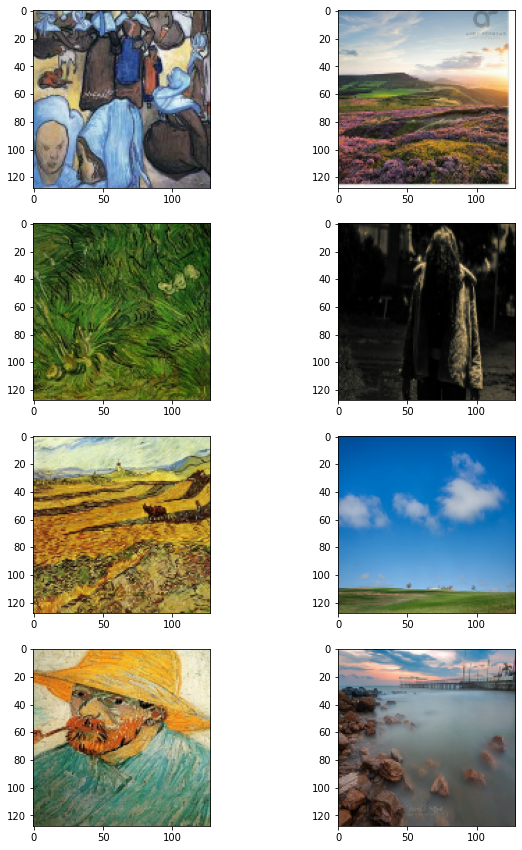

In [ ]:
_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, samples in enumerate(zip(train_vangogh.take(4), train_photo.take(4))):
    vangogh = (((samples[0][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    photo = (((samples[1][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    ax[i, 0].imshow(vangogh)
    ax[i, 1].imshow(photo)
plt.show()

In [ ]:
path = '2013-11-08 16_45_24.jpg'
ng = 64
nd = 64
no_of_styles = 4

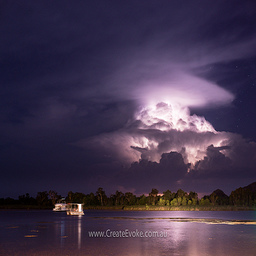

In [ ]:
gimage = Image.open(path)
gimage

In [ ]:
image = cv2.imread(path)
image = cv2.resize(image, (128, 128))
#image =  Image.BICUBIC(image)
image.shape

(128, 128, 3)

In [ ]:
from tensorflow.keras.layers import ReLU, Input, BatchNormalization, Lambda, Conv2DTranspose
from tensorflow.keras.activations import tanh

def generator():
  in_image = Input(shape=(128,128,3))
  g = encoder(in_image)
  g = transformer(input_layer = g)
  out_image = decoder(input_layer = g)

  model = tf.keras.Model(in_image, out_image)
  return model

  """def __init__(self, n_styles, ng):

    self.encoder = encoder(ng)
    self.transformer = transformer(no_of_styles, ng)
    self.decoder = decoder(ng)

  def __call__(self, training):
    e = self.encoder()
    t = self.transformer(e)
    d = self.decoder(t)
    return d"""


def encoder(input, ng=64):
  e = Lambda(lambda x: tf.pad(x, [[0,0], [27,27], [27,27], [0,0]], 'REFLECT'))(input) 
  e = layers.Conv2D(ng, kernel_size=(7, 7))(e)
  e = tfa.layers.InstanceNormalization()(e) #instance normalization
  e = ReLU()(e)

  op_f = ng * 2

  e = layers.Conv2D(op_f, kernel_size=(3, 3), strides=2, padding ="same")(e) 
  e = tfa.layers.InstanceNormalization()(e) #instance normalization
  e = ReLU()(e)

  op_f = op_f * 2

  e = layers.Conv2D(op_f, kernel_size=(3, 3), strides=2, padding ="same")(e)
  e = tfa.layers.InstanceNormalization()(e) #instance normalization
  e = ReLU()(e)

  e = tf.keras.layers.Concatenate()([e, input])


def resnet_block(n_filters, input_layer):
  # first layer convolutional layer
  g = layers.Conv2D(n_filters, (3,3), padding='same')(input_layer)
  g = tfa.layers.InstanceNormalization(axis=-1)(g)
  g = ReLU(g)
  # second convolutional layer
  g = layers.Conv2D(n_filters, (3,3), padding='same')(g)
  g = tfa.layers.InstanceNormalization(axis=-1)(g)
  # concatenate merge channel-wise with input layer
  g = tf.keras.layers.Concatenate()([g, input_layer])
  return g


def transformer(input_layer, no_of_styles=4, ng=64):
  t = resnet_block(ng*4, input_layer)
  for _ in range(no_of_styles-1):
    t = resnet_block(ng*4, t)
  t = tf.keras.layers.Concatenate()([t, input_layer])
  return t



  """def __call__(self, x):
    tr = []
    for i in range(self.no_of_styles):
      tr.append(residual_block(self.ng*4, x))
    self.t = tr  
    self.t.append(x) #not sure exactly what this is doing here

    label = x[1][0]
    trans_content = np.sum([self.t[i](x[0])*j for (i,j) in enumerate(label) if j])
    return trans_content

  def __call__(self, x):
    tr = []
    for i in range(self.no_of_styles):
      tr.append(residual_block(self.ng*4, x))
    return tr"""

def decoder(input_layer, ng=64):
  in_f = ng * 4
  op_f = in_f//2

  d = resnet_block(in_f, input_layer)
  for _ in range(4):
    d = resnet_block(ng*4, d)
  
  d = Conv2DTranspose(op_f, (3, 3), strides=2, padding ="same")(d)
  d = tfa.layers.InstanceNormalization()(d)
  d = ReLU()(d)

  op_f = op_f//2

  d = Conv2DTranspose(ng//4, (3, 3), strides=2, padding ="same")(d)
  d = tfa.layers.InstanceNormalization()(d)
  d = ReLU()(d)

  d = Lambda(lambda x: tf.pad(x, [[0,0], [27,27], [27,27], [0,0]], 'REFLECT'))(d)
  d = layers.Conv2D(3, (7, 7), strides=2, padding ="same", activation ="tanh")(d)

  d = tf.keras.layers.Concatenate()([d, input_layer])
  return d



"""class decoder():
  def __init__(self, ng):
    self.ng = ng

  def __call__(self, x):
    in_f = self.ng * 4
    op_f = in_f//2
    dmodel = []
    for i in range(5):
      dmodel += [residual_block(in_f, x)]

    for i in range(2):
      dmodel += [ Conv2DTranspose(op_f, (3, 3), strides=2, padding ="same"),
                 tfa.layers.InstanceNormalization(),
                 ReLU()                 
      ]
      op_f = op_f//2

    dmodel += [ Lambda(lambda x: tf.pad(x, [[0,0], [27,27], [27,27], [0,0]], 'REFLECT')),
                layers.Conv2D(3, (7, 7), strides=2, padding ="same", activation ="tanh")
                ]

    self.dmodel = keras.models.Model(dmodel)
    return self.dmodel"""


'class decoder():\n  def __init__(self, ng):\n    self.ng = ng\n\n  def __call__(self, x):\n    in_f = self.ng * 4\n    op_f = in_f//2\n    dmodel = []\n    for i in range(5):\n      dmodel += [residual_block(in_f, x)]\n\n    for i in range(2):\n      dmodel += [ Conv2DTranspose(op_f, (3, 3), strides=2, padding ="same"),\n                 tfa.layers.InstanceNormalization(),\n                 ReLU()                 \n      ]\n      op_f = op_f//2\n\n    dmodel += [ Lambda(lambda x: tf.pad(x, [[0,0], [27,27], [27,27], [0,0]], \'REFLECT\')),\n                layers.Conv2D(3, (7, 7), strides=2, padding ="same", activation ="tanh")\n                ]\n\n    self.dmodel = keras.models.Model(dmodel)\n    return self.dmodel'

In [ ]:
from tensorflow.keras.layers import LeakyReLU

def discriminator(nd=64, no_of_styles=4): 
  op_f = nd
  in_image = Input(shape=(128,128,3))
  x = layers.Conv2D(op_f, kernel_size=(4, 4), strides=2, padding = "same")(in_image)
  x = tfa.layers.InstanceNormalization()(x)
  x = LeakyReLU(alpha = 0.3)(x)

  op_f = op_f * 2

  x = layers.Conv2D(op_f, kernel_size=(4, 4), strides=2, padding = "same")(x)
  x = tfa.layers.InstanceNormalization()(x)
  x = LeakyReLU(alpha = 0.3)(x)

  op_f = op_f * 2

  x = layers.Conv2D(op_f, kernel_size=(4, 4), strides = 1, padding = "same")(x)
  x = tfa.layers.InstanceNormalization()(x)
  base = LeakyReLU(alpha = 0.3)(x)
  
  out1 = layers.Conv2D(1, kernel_size=(4, 4), padding = "same")(base)
  #out2 = layers.Conv2D(4, kernel_size=(4, 4), padding = "same")(base).transpose(1,3) #this is the aux classifier somehow -> need to figure out how to fix

  #return discriminate #[discriminate, classifier]
  discriminate = tf.keras.Model(in_image, out1)
  #classifier = tf.keras.Model(in_image, out2)
  return discriminate #,classifier

"""class Discriminator():
  def __init__(self, no_of_styles, nd):
    self.op_f = nd
    self.no_of_styles = no_of_styles


   dismodel = []

    for i in range(2):
      dismodel += [layers.Conv2D(self.op_f, kernel_size=(4, 4), strides=2, padding = "same"),
                tfa.layers.InstanceNormalization(),
                LeakyReLU(alpha = 0.3)]

      self.op_f = self.op_f * 2


    dismodel += [layers.Conv2D(self.op_f, kernel_size=(4, 4), strides = 1, padding = "same"),
                tfa.layers.InstanceNormalization(),
                LeakyReLU(alpha = 0.3)]
                
    self.dismodel = dismodel
    self.dismodel1 = keras.models.Model(self.dismodel)(x)

  
  def __call__(self, x):

    img_input = layers.Input(shape=(128,128,3))
    x = layers.Conv2D(self.op_f, kernel_size=(4, 4), strides=2, padding = "same")(img_input)
    x = tfa.layers.InstanceNormalization()(x)
    x = LeakyReLU(alpha = 0.3)(x)

    self.op_f = self.op_f * 2

    x = layers.Conv2D(self.op_f, kernel_size=(4, 4), strides=2, padding = "same")(x)
    x = tfa.layers.InstanceNormalization()(x)
    x = LeakyReLU(alpha = 0.3)(x)

    self.op_f = self.op_f * 2

    x = layers.Conv2D(self.op_f, kernel_size=(4, 4), strides = 1, padding = "same")(x)
    x = tfa.layers.InstanceNormalization()(x)
    base = LeakyReLU(alpha = 0.3)(x)
    
    discriminate = layers.Conv2D(1, kernel_size=(4, 4), padding = "same")(base)
    #classifier = layers.Conv2D(4, kernel_size=(4, 4), padding = "same")(base).transpose(1,3) #this is the aux classifier somehow -> need to figure out how to fix

    return discriminate #[discriminate, classifier]"""

'class Discriminator():\n  def __init__(self, no_of_styles, nd):\n    self.op_f = nd\n    self.no_of_styles = no_of_styles\n\n\n   dismodel = []\n\n    for i in range(2):\n      dismodel += [layers.Conv2D(self.op_f, kernel_size=(4, 4), strides=2, padding = "same"),\n                tfa.layers.InstanceNormalization(),\n                LeakyReLU(alpha = 0.3)]\n\n      self.op_f = self.op_f * 2\n\n\n    dismodel += [layers.Conv2D(self.op_f, kernel_size=(4, 4), strides = 1, padding = "same"),\n                tfa.layers.InstanceNormalization(),\n                LeakyReLU(alpha = 0.3)]\n                \n    self.dismodel = dismodel\n    self.dismodel1 = keras.models.Model(self.dismodel)(x)\n\n  \n  def __call__(self, x):\n\n    img_input = layers.Input(shape=(128,128,3))\n    x = layers.Conv2D(self.op_f, kernel_size=(4, 4), strides=2, padding = "same")(img_input)\n    x = tfa.layers.InstanceNormalization()(x)\n    x = LeakyReLU(alpha = 0.3)(x)\n\n    self.op_f = self.op_f * 2\n\n    x = la

In [ ]:
class ReflectionPadding2D(layers.Layer):
    """Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x


def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x

In [ ]:
def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(
        x
    )
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model

In [ ]:
def get_discriminator(
    filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer
    )(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model

In [ ]:
# Get the generators
gen_G = get_resnet_generator(name="generator_G")
gen_F = get_resnet_generator(name="generator_F")

# Get the discriminators
disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(name="discriminator_Y")

In [ ]:
# Get the generators
gen_G = Generator(4, ng)
gen_F = Generator(4, ng)

# Get the discriminators
disc_X = Discriminator(4, nd)
disc_Y = Discriminator(4, nd)

In [ ]:
# Get the generators
gen_G = generator()
gen_F = generator()

# Get the discriminators
disc_X = discriminator()
disc_Y = discriminator()

ValueError: ignored

In [ ]:
class CycleGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super(CycleGan, self).__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super(CycleGan, self).compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        # x is Horse and y is zebra
        real_x, real_y = batch_data

        # For CycleGAN, we need to calculate different
        # kinds of losses for the generators and discriminators.
        # We will perform the following steps here:
        #
        # 1. Pass real images through the generators and get the generated images
        # 2. Pass the generated images back to the generators to check if we
        #    we can predict the original image from the generated image.
        # 3. Do an identity mapping of the real images using the generators.
        # 4. Pass the generated images in 1) to the corresponding discriminators.
        # 5. Calculate the generators total loss (adverserial + cycle + identity)
        # 6. Calculate the discriminators loss
        # 7. Update the weights of the generators
        # 8. Update the weights of the discriminators
        # 9. Return the losses in a dictionary

        with tf.GradientTape(persistent=True) as tape:
            # Horse to fake zebra
            fake_y = self.gen_G(real_x)
            # Zebra to fake horse -> y2x
            fake_x = self.gen_F(real_y)

            # Cycle (Horse to fake zebra to fake horse): x -> y -> x
            cycled_x = self.gen_F(fake_y)
            # Cycle (Zebra to fake horse to fake zebra) y -> x -> y
            cycled_y = self.gen_G(fake_x)

            # Identity mapping
            same_x = self.gen_F(real_x)
            same_y = self.gen_G(real_y)

            # Discriminator output
            disc_real_x = self.disc_X(real_x)
            disc_fake_x = self.disc_X(fake_x)

            disc_real_y = self.disc_Y(real_y)
            disc_fake_y = self.disc_Y(fake_y)

            # Generator adverserial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }

In [ ]:
class CycleGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super(CycleGan, self).__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super(CycleGan, self).compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        # x is Horse and y is zebra
        real_x, real_y = batch_data

        # For CycleGAN, we need to calculate different
        # kinds of losses for the generators and discriminators.
        # We will perform the following steps here:
        #
        # 1. Pass real images through the generators and get the generated images
        # 2. Pass the generated images back to the generators to check if we
        #    we can predict the original image from the generated image.
        # 3. Do an identity mapping of the real images using the generators.
        # 4. Pass the generated images in 1) to the corresponding discriminators.
        # 5. Calculate the generators total loss (adverserial + cycle + identity)
        # 6. Calculate the discriminators loss
        # 7. Update the weights of the generators
        # 8. Update the weights of the discriminators
        # 9. Return the losses in a dictionary

        with tf.GradientTape(persistent=True) as tape:
            # Horse to fake zebra
            fake_y = self.gen_G(real_x, training=True)
            # Zebra to fake horse -> y2x
            fake_x = self.gen_F(real_y, training=True)

            # Cycle (Horse to fake zebra to fake horse): x -> y -> x
            cycled_x = self.gen_F(fake_y, training=True)
            # Cycle (Zebra to fake horse to fake zebra) y -> x -> y
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adverserial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }

In [ ]:
class GatedGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_total_variation=0.5,
    ):
        super(GatedGan, self).__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_total_variation = lambda_total_variation

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super(GatedGan, self).compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError() #this is the same as paper
        #self.total_variation_loss_fn = tf.image.total_variation()

   # def __call__(self, training = False):
    #  return 0

    def train_step(self, batch_data, training = False):
        # x is real_photo and y is painted_image
        real_x, real_y = batch_data

        # For CycleGAN, we need to calculate different
        # kinds of losses for the generators and discriminators.
        # We will perform the following steps here:
        #
        # 1. Pass real images through the generators and get the generated images
        # 2. Pass the generated images back to the generators to check if we
        #    we can predict the original image from the generated image.
        # 3. Do an identity mapping of the real images using the generators.
        # 4. Pass the generated images in 1) to the corresponding discriminators.
        # 5. Calculate the generators total loss (adverserial + cycle + variation)
        # 6. Calculate the discriminators loss
        # 7. Update the weights of the generators
        # 8. Update the weights of the discriminators
        # 9. Return the losses in a dictionary

        with tf.GradientTape(persistent=True) as tape:
            # real_photo to fake painted_image
            fake_y = self.gen_G(real_x, training=True)
            # painted_image to fake real_photo -> y2x
            fake_x = self.gen_F(real_y, training=True)

            # Cycle (real_photo to fake painted to fake real_photo): x -> y -> x
            cycled_x = self.gen_F(fake_y, training=True)
            # Cycle (Zebra to fake horse to fake zebra) y -> x -> y
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adverserial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Total Variation Loss

            # Generator identity loss
            total_variation_loss_G = (
                tf.image.total_variation(fake_y)
                * self.lambda_total_variation
            )
            total_variation_loss_F = (
                tf.image.total_variation(fake_x)
                * self.lambda_total_variation
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + total_variation_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + total_variation_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=4):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        _, ax = plt.subplots(4, 2, figsize=(12, 12))
        for i, img in enumerate(test_photo.take(self.num_img)):
            prediction = self.model.gen_G(img)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

            ax[i, 0].imshow(img)
            ax[i, 1].imshow(prediction)
            ax[i, 0].set_title("Input image")
            ax[i, 1].set_title("Translated image")
            ax[i, 0].axis("off")
            ax[i, 1].axis("off")

            prediction = keras.preprocessing.image.array_to_img(prediction)
            prediction.save(
                "generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch + 1)
            )
        plt.show()
        plt.close()

In [ ]:
# Loss function for evaluating adversarial loss
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss


# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5


# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)
# Callbacks
plotter = GANMonitor()
checkpoint_filepath = "./model_checkpoints/cyclegan_checkpoints.{epoch:03d}"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath
)

# Here we will train the model for just one epoch as each epoch takes around
# 7 minutes on a single P100 backed machine.
cycle_gan_model.fit(
    tf.data.Dataset.zip((train_photo, train_vangogh)),
    epochs=1,
    callbacks=[plotter, model_checkpoint_callback],
)

TypeError: ignored